In [0]:
!wget -q https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip
!rm data.zip

replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import glob 
import unicodedata
import string 
import os 
import torch 

def findFiles(filepath): return glob.glob(filepath)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' 
      and c in all_letters
  )

print(unicodeToAscii('đau để trưởng thành.'))

category_lines = {}
all_categories = []

def readlines(filename):
  lines = open(filename, encoding='utf8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readlines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Korean.txt', 'data/names/Arabic.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/English.txt']
au e truong thanh.


In [0]:
category_lines['Vietnamese'][:5]

['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']

In [0]:
def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor 

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToIndex('C'))
print(lineToTensor('Cong').size())

28
torch.Size([4, 1, 57])


In [0]:
import torch.nn as nn 
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.log_softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.log_softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros((1, self.hidden_size)).to(device)

device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 128
rnn = RNN(n_letters, hidden_size, n_categories).to(device)

In [0]:
# Test model 
input = letterToTensor('A').to(device)
hidden = torch.zeros((1, hidden_size)).to(device)
output, hidden = rnn(input, hidden)
print(output)
print(hidden)

tensor([[-2.8834, -2.8024, -2.8279, -2.8532, -2.9149, -2.9552, -2.9419, -2.9472,
         -2.8736, -2.8513, -2.9392, -2.9608, -2.9086, -2.7750, -2.9209, -2.9106,
         -2.8835, -2.9013]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor([[-0.0435, -0.0323, -0.0082,  0.0600,  0.0094, -0.0267, -0.0890,  0.0874,
          0.0619,  0.0384, -0.1034,  0.0524,  0.0239, -0.0663,  0.1137, -0.0378,
         -0.0346, -0.0339, -0.0005,  0.0528, -0.0822, -0.0621,  0.0303,  0.0760,
          0.0348, -0.0122, -0.0121, -0.0229,  0.1210, -0.0864,  0.1314,  0.0650,
          0.0355, -0.0341, -0.0036, -0.0616, -0.0262,  0.0621,  0.0148, -0.0211,
          0.0242,  0.0472,  0.0976,  0.0591,  0.0090, -0.0395, -0.0154, -0.0203,
          0.0052,  0.0598, -0.0089, -0.0139,  0.0523, -0.0594, -0.0567,  0.0754,
          0.0342, -0.0976, -0.1161, -0.0863, -0.0749, -0.0161, -0.0272,  0.0455,
          0.0933,  0.0462, -0.0476, -0.0774,  0.0454,  0.0325, -0.0798,  0.0983,
          0.0322, -0.1027, -0.007

In [0]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


In [0]:
import random 

def randomChoice(l):
  return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.LongTensor([all_categories.index(category)]).to(device)
  line_tensor = lineToTensor(line).to(device)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category = ', category, '/ line = ', line)

category =  English / line =  Buckley
category =  Chinese / line =  Shaw
category =  French / line =  Bonhomme
category =  Italian / line =  Lagana
category =  Korean / line =  Chang
category =  Dutch / line =  Klerkse
category =  Portuguese / line =  Coelho
category =  English / line =  Rawlinson
category =  Russian / line =  Tumenov
category =  Greek / line =  Papadopulos


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 5e-3 

def train(category_tensor, line_tensor):
  hidden = rnn.init_hidden()
  
  rnn.zero_grad()

  for  i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for param in rnn.parameters():
    param.data.add_(-learning_rate, param.grad.data)
  
  return output, loss.item()

In [0]:
import time 
import math 

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0 
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since 
  m = s // 60
  s -= m*60
  return " %dm %ds " %(m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss 

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
  
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% ( 0m 16s ) 2.4815 Sloan / Arabic ✗ (Irish)
10000 10% ( 0m 33s ) 2.3432 Gentile / Scottish ✗ (Italian)
15000 15% ( 0m 49s ) 1.7553 Shelyakin / Russian ✓
20000 20% ( 1m 6s ) 2.7457 Rumpade / French ✗ (Dutch)
25000 25% ( 1m 22s ) 3.2576 Niftrik / Czech ✗ (Dutch)
30000 30% ( 1m 38s ) 2.3922 Dempster / German ✗ (English)
35000 35% ( 1m 55s ) 1.6399 Hierro / Portuguese ✗ (Spanish)
40000 40% ( 2m 12s ) 3.6381 Roosa / Spanish ✗ (Dutch)
45000 45% ( 2m 29s ) 0.5949 Nannini / Italian ✓
50000 50% ( 2m 45s ) 0.1586 O'Ryan / Irish ✓
55000 55% ( 3m 1s ) 1.5621 Lim / Chinese ✓
60000 60% ( 3m 17s ) 0.8679 Amari / Arabic ✓
65000 65% ( 3m 34s ) 0.9192 Dubhain / Irish ✓
70000 70% ( 3m 50s ) 0.0944 O'Malley / Irish ✓
75000 75% ( 4m 6s ) 1.8448 Grec / German ✗ (Spanish)
80000 80% ( 4m 22s ) 1.6745 Gomes / Dutch ✗ (Portuguese)
85000 85% ( 4m 39s ) 0.1664 Mustafa / Arabic ✓
90000 90% ( 4m 54s ) 0.7175 Riain / Irish ✓
95000 95% ( 5m 11s ) 0.0521 Passerini / Italian ✓
100000 100% ( 5m 27s ) 2.7869 Ajdrn

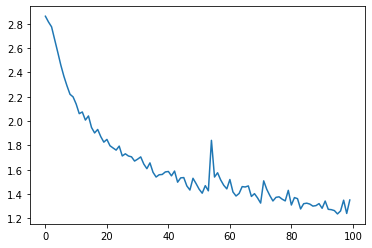

In [0]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 

plt.figure()
plt.plot(all_losses)

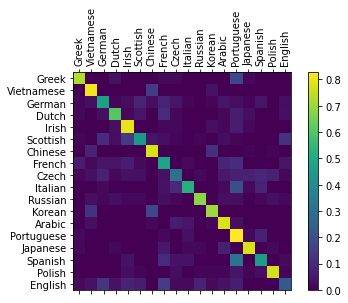

In [0]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

def evaluate(line_tensor):
  hidden = rnn.init_hidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output
  
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess_n, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i]/confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()